In [43]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import urllib
import urllib.request
from random import randint
from time import sleep
from bs4 import BeautifulSoup 
import os

C:\Users\The3J\AppData\Local\Temp\ipykernel_24240\2134697714.py:52: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dft26 = pd.read_html(str(table))[0]


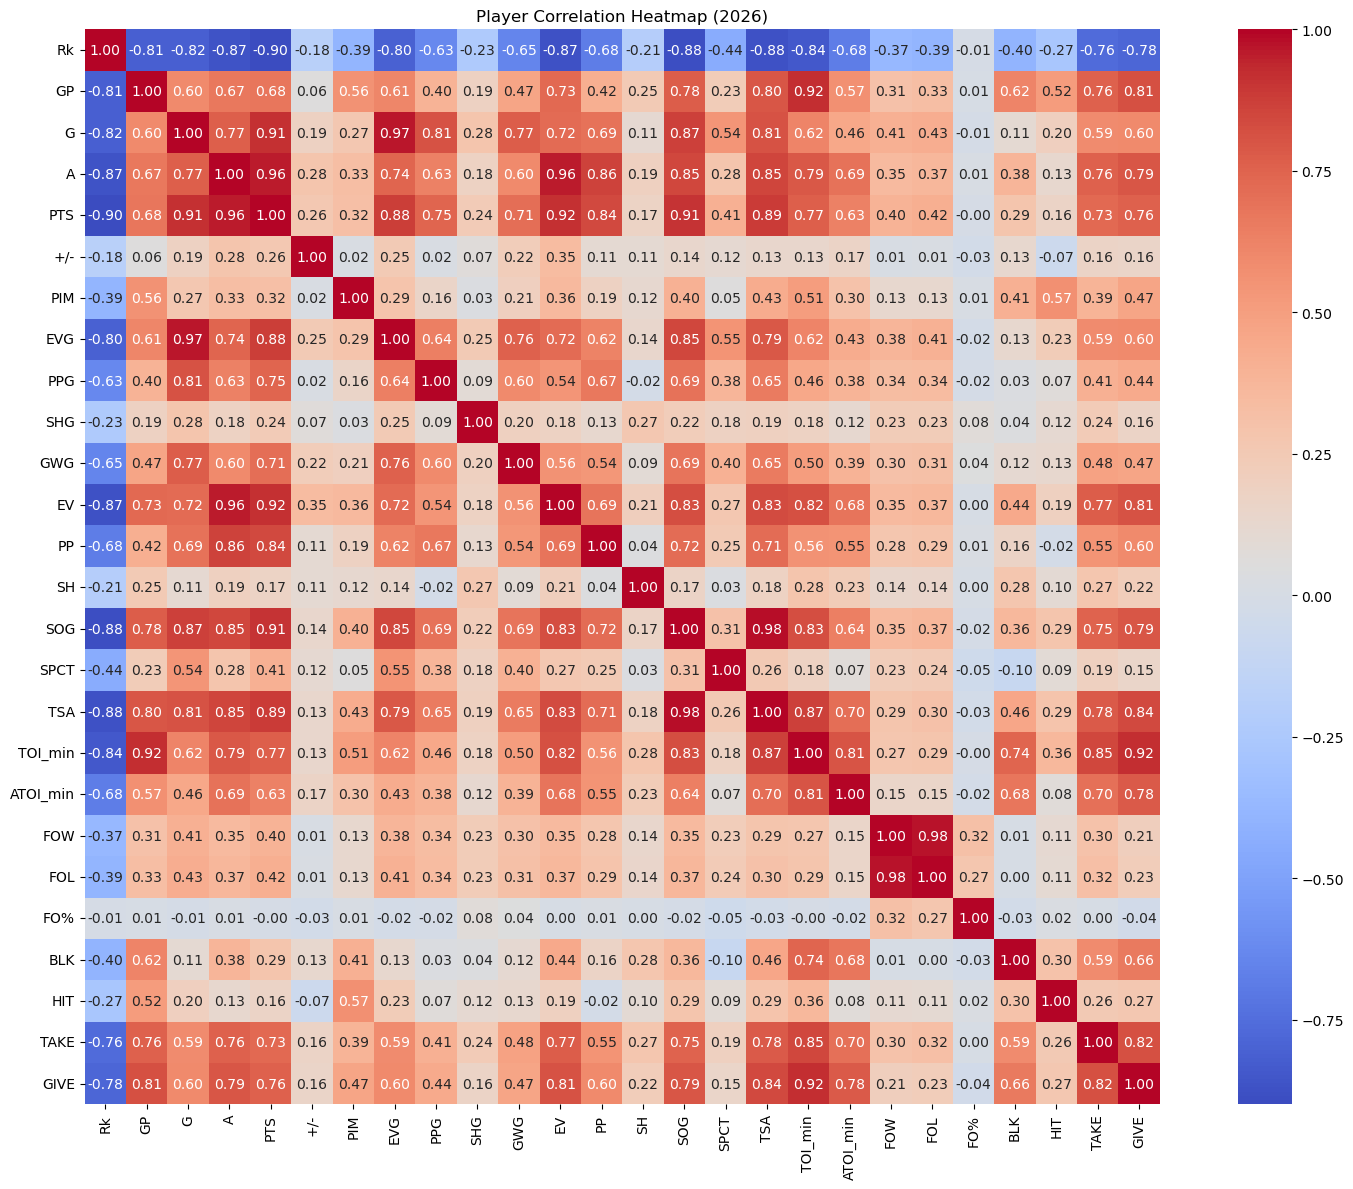

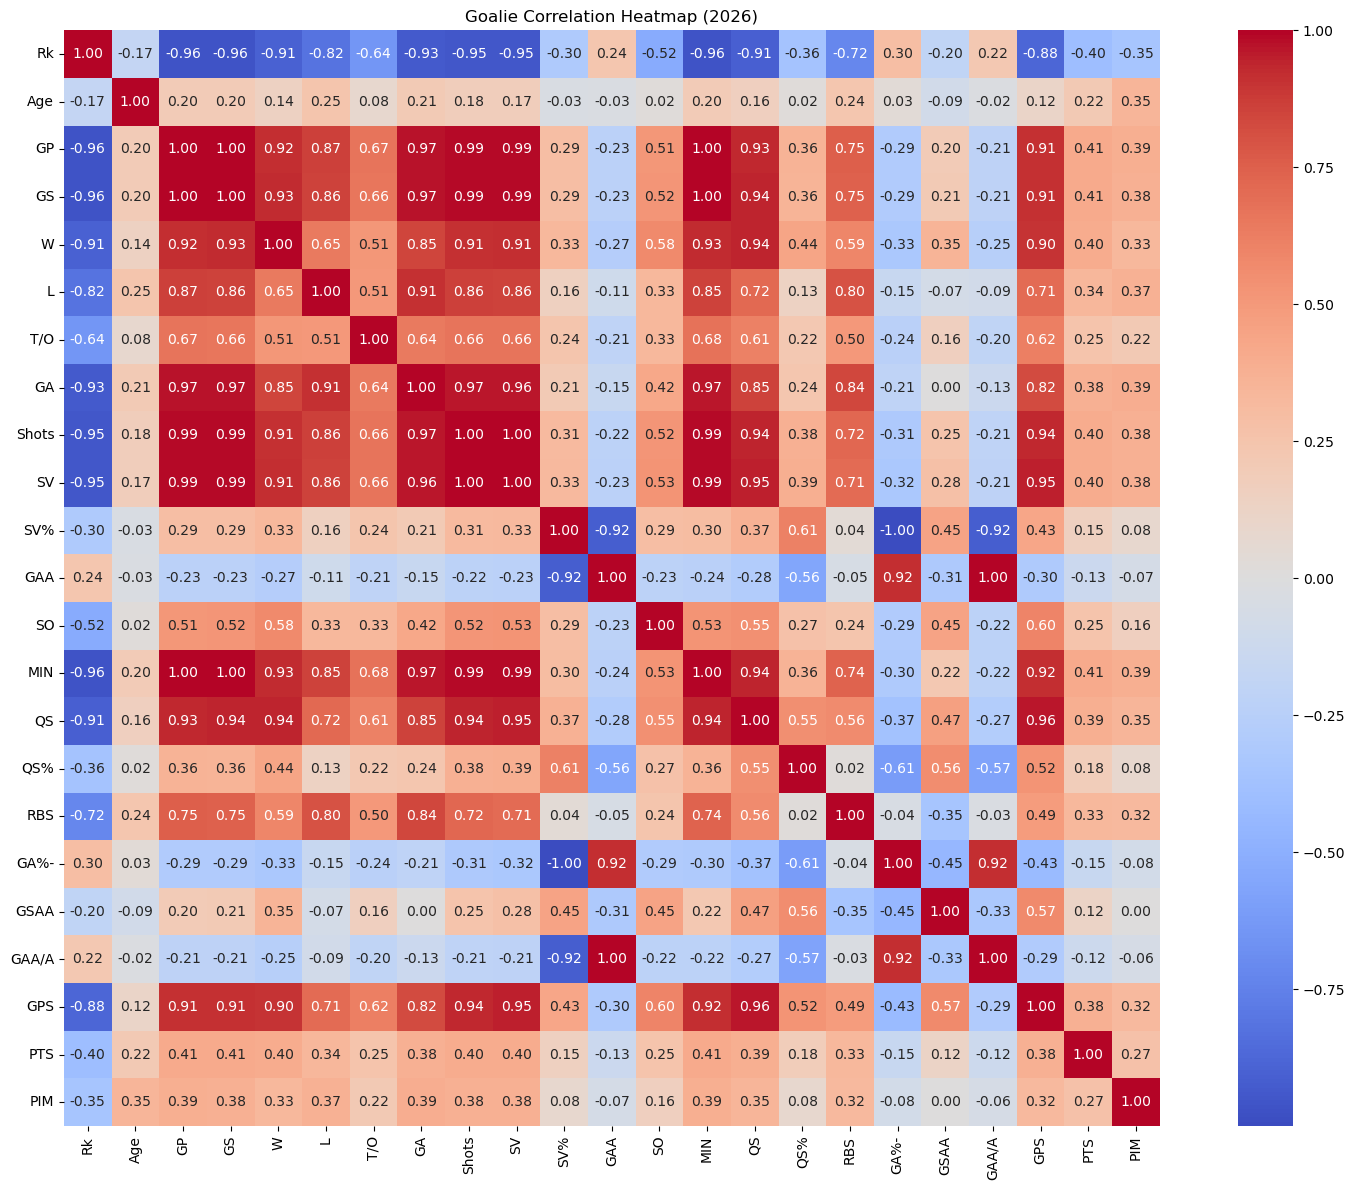

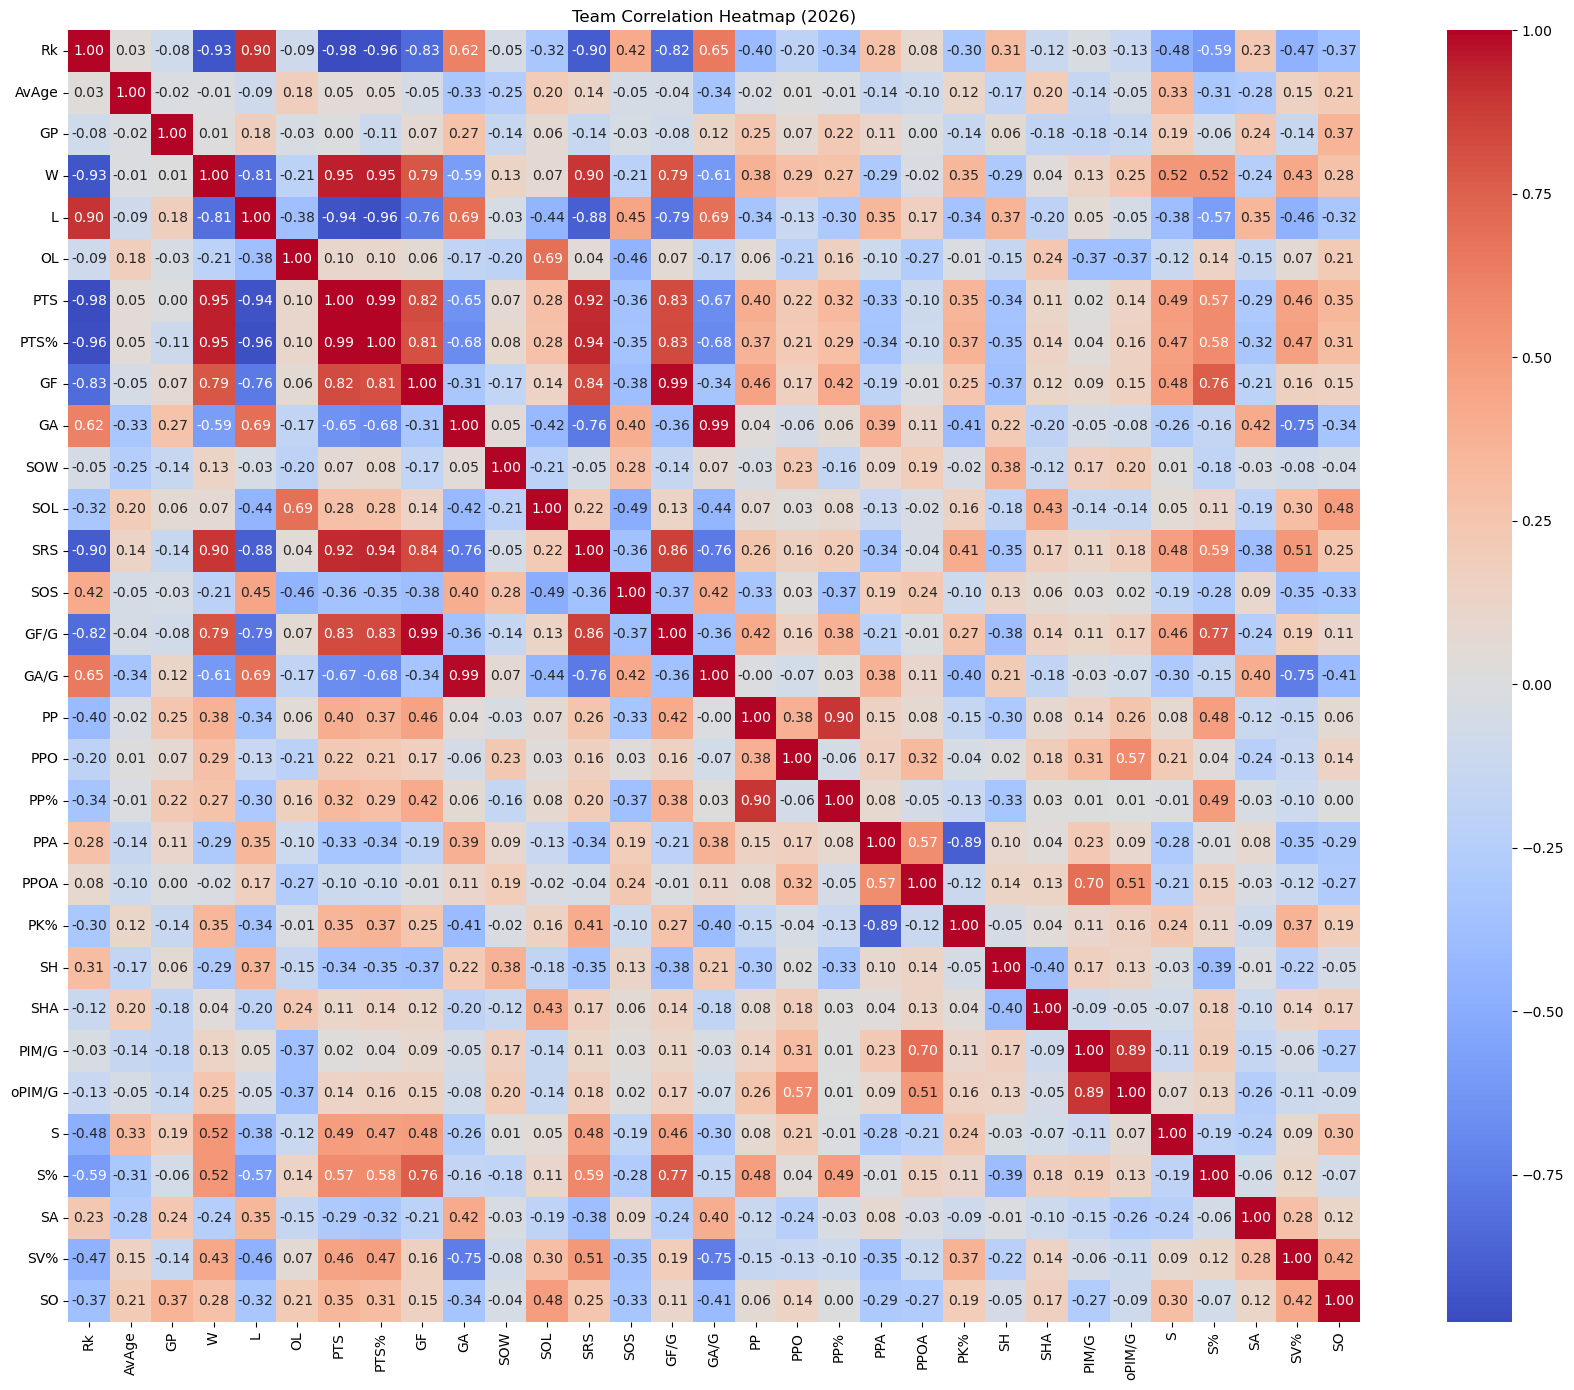

In [23]:
# Import Player Data for 2026 Season
urlp = "https://www.hockey-reference.com/leagues/NHL_2026_skaters.html"
dfs = pd.read_html(urlp)

# Clean Up Data
dfp = dfs[0] 
dfp26 = dfp.dropna(how='all', axis=1, inplace=True) # Removes columns that have entirely NaN data; i.e. Awards column
dfp26= dfp.drop(dfp.index[-1]) # Removes last row, League Avg
dfp26.columns = dfp.columns.droplevel(0) # Removes first headers
dfp26 = dfp26[dfp26['Pos'] != 'G'] # Exclude Goalie position, They Get They're Own Data

# Import and Clean Goalie Data
urlg = "https://www.hockey-reference.com/leagues/NHL_2026_goalies.html"
dfg = pd.read_html(urlg)
dfl = dfg[0]
dfg26 = dfl.dropna(how='all', axis=1, inplace=True)
dfg26 = dfl.drop(dfl.index[-1])
dfg26.columns = dfl.columns.droplevel(0)

#Team Data 2026, a bit weirder to scrape
url = "https://www.hockey-reference.com/leagues/NHL_2026.html"
res = requests.get(url)
soup = BeautifulSoup(res.text, 'lxml')

comments = soup.find_all(string=lambda text: isinstance(text, Comment))

# Find the team stats table in comments
team_stats_html = None
for comment in comments:
    if 'table' in comment and 'stats' in comment:
        team_stats_html = comment
        break

# Parse the table with pandas
if team_stats_html:
    stats_soup = BeautifulSoup(team_stats_html, 'lxml')
    table = stats_soup.find('table', {'id': 'stats'})
    
    dft26 = pd.read_html(str(table))[0]
else:
    print("Table not found in comments. Trying direct table search...")
    table = soup.find('table', {'id': 'stats'})
    if table:
        dft26 = pd.read_html(str(table))[0]

# Clean data, not much to do 
dft26.columns = dft26.columns.droplevel(0)
dft26 = dft26.drop(dft26.index[-1])
dft26.rename(columns={"Unnamed: 1_level_1":"Team"}, inplace=True)

# Converting Strings to Numbers
def time_to_minutes(t):
    if pd.isna(t):
        return None
    parts = list(map(int, t.split(':')))
    if len(parts) == 2:      # MM:SS
        m, s = parts
        return m + s / 60
    elif len(parts) == 3:    # HH:MM:SS
        h, m, s = parts
        return h * 60 + m + s / 60

dfp26['TOI_min'] = dfp26['TOI'].apply(time_to_minutes)
dfp26['ATOI_min'] = dfp26['ATOI'].apply(time_to_minutes)

# Correlation Matrix for Players
corrp = dfp26[['Rk', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'EVG', 'PPG', 'SHG', 'GWG', 'EV', 'PP', 'SH', 'SOG', 'SPCT', 'TSA', 'TOI_min', 'ATOI_min', 'FOW', 'FOL', 'FO%', 'BLK', 'HIT', 'TAKE', 'GIVE']].corr()

# PVisual
plt.figure(figsize=(16, 12))
sns.heatmap(corrp, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Player Correlation Heatmap (2026)")
plt.tight_layout()  # Data that has higher negative correlation to Rank, means its more correlated. 1 is a low number but a high rank

# Goalie Matrix
dfg26['MIN'] = dfg26['MIN'].apply(time_to_minutes)
corrg = dfg26[['Rk', 'Age', 'GP', 'GS', 'W', 'L', 'T/O', 'GA', 'Shots', 'SV', 'SV%', 'GAA', 'SO', 'MIN', 'QS', 'QS%', 'RBS', 'GA%-', 'GSAA', 'GAA/A', 'GPS', 'PTS', 'PIM']].corr()

# GVisual
plt.figure(figsize=(16, 12))
sns.heatmap(corrg, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Goalie Correlation Heatmap (2026)")
plt.tight_layout() #Same Negative Correlation Situation here

# Team Matrix
corrt = dft26[["Rk", "AvAge", "GP", "W", "L", "OL", "PTS", "PTS%", "GF", "GA", "SOW", "SOL", "SRS", "SOS", "GF/G", "GA/G", "PP", "PPO", "PP%", "PPA", "PPOA", "PK%", "SH", "SHA", "PIM/G", "oPIM/G", "S", "S%", "SA", "SV%", "SO"]].corr()

# Team Vis
plt.figure(figsize=(18, 14))
sns.heatmap(corrt, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Team Correlation Heatmap (2026)")
plt.tight_layout() # Again negative Corr with rank means high corr, and high corr means neg

dfp26.to_csv('NHL_Player_Stats_2026.csv')
dfg26.to_csv('NHL_Goalie_Stats_2026.csv')
dft26.to_csv('NHL_Team_Stats_2026.csv')